## setting

In [86]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy
device = torch.device('cuda')


Mounted at /content/drive


In [2]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 600

hidden_size3 = 400

hidden_size4 = 200

hidden_size5 = 100

hidden_size6 = 50

hidden_size7 = 20

num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5,hidden_size6,hidden_size7,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.hidden_size1 = hidden_size1
        #self.fc1.weight.detach().normal_(0.0, 0.1)
        #self.fc1.bias.detach().normal_(0.0, 0.1)
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        #self.fc2.weight.detach().uniform_(-1,1)
        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, hidden_size4,bias=False)




        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.relu3 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size5, hidden_size6,bias=False)
        


        self.fc7 = nn.Linear(hidden_size6, hidden_size7)
        self.relu4 = nn.ReLU()
        self.fc8 = nn.Linear(hidden_size7, num_classes,bias=False)


        self.lsm=nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        
        
        out = self.fc3(out)
        out = self.relu2(out)
        out = self.fc4(out)
        
        out = self.fc5(out)
        out = self.relu3(out)
        out = self.fc6(out)

        out = self.fc7(out)
        out = self.relu4(out)
        out = self.fc8(out)


        out = self.lsm(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

## Original Training

In [77]:
learning_rate = 0.005
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5,hidden_size6,hidden_size7,num_classes).to(device)
ad=False
if ad:
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1)
    #adjust(model,images,threshold_u=1,threshold_l=0.01,scale=0.8)
    adjust(model,images,threshold_u=10,threshold_l=0.01,scale=0.8,ln=1,oflag=1)
    #adjust(model,images,threshold_u=10,threshold_l=1,scale=0.8)
    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
num_epochs=700
dev=100
losslist=[]


totalloss=[]



model.fc2.register_forward_hook(get_activation('fc2'))
model.fc4.register_forward_hook(get_activation('fc4'))
model.fc6.register_forward_hook(get_activation('fc6'))

count=0
dd=1
de=1
for epoch in range(num_epochs):
    loss_epoch=0
    for i, (images, labels) in enumerate(train_loader):  
        

        images = images.view(images.shape[0], -1).to(device)
        labels=labels.to(device)
        #print(images,labels)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        
        
        totalloss.append(loss.item())

        loss_epoch=loss_epoch+loss.item()       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count=count+1

        if ad:
            if count==de*dd:
                with torch.no_grad():
                    output = model(images)
                    adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.01,scale=0.8,ln=2*de+1,oflag=1)
                    if de<3:
                        de=de+1
                    else:
                        de=-1
                    
                    
        
    loss_epoch=loss_epoch/len(train_loader) 
    losslist.append(loss_epoch)
    
    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
    if loss_epoch<0.02:
        break

KeyboardInterrupt: ignored

In [26]:
accuracy(model.to(device),valloader)

Accuracy: 97.3500 %


## Modify first layer

In [78]:
learning_rate = 0.005
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5,hidden_size6,hidden_size7,num_classes).to(device)
ad=True
if ad:
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1)
    adjust(model,images,threshold_u=10,threshold_l=0.01,scale=0.8,ln=1,oflag=1)
    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
num_epochs=700
losslist=[]


totalloss=[]



model.fc2.register_forward_hook(get_activation('fc2'))
model.fc4.register_forward_hook(get_activation('fc4'))
model.fc6.register_forward_hook(get_activation('fc6'))

count=0
dd=1
de=1
for epoch in range(num_epochs):
    loss_epoch=0
    for i, (images, labels) in enumerate(train_loader):  
        

        images = images.view(images.shape[0], -1).to(device)
        labels=labels.to(device)
        #print(images,labels)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        
        
        totalloss.append(loss.item())

        loss_epoch=loss_epoch+loss.item()       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count=count+1

        if ad:
            if count==de*dd:
                with torch.no_grad():
                    output = model(images)
                    adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.01,scale=0.8,ln=2*de+1,oflag=1)
                    if de<3:
                        de=de+1
                    else:
                        de=-1
                    
                    
        
    loss_epoch=loss_epoch/len(train_loader) 
    losslist.append(loss_epoch)
    
    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
    if loss_epoch<0.02:
        break

Adjusting Layer 1, Kernel Nodes: 495, Adptive Nodes305
Adjusting Layer 3, Kernel Nodes: 273, Adptive Nodes127
Adjusting Layer 5, Kernel Nodes: 67, Adptive Nodes33
Adjusting Layer 7, Kernel Nodes: 15, Adptive Nodes5
Epoch [1/700], Loss: 0.6359
Epoch [2/700], Loss: 0.2302
Epoch [3/700], Loss: 0.1619
Epoch [4/700], Loss: 0.1293
Epoch [5/700], Loss: 0.1077
Epoch [6/700], Loss: 0.0893
Epoch [7/700], Loss: 0.0760
Epoch [8/700], Loss: 0.0658
Epoch [9/700], Loss: 0.0577
Epoch [10/700], Loss: 0.0523
Epoch [11/700], Loss: 0.0466
Epoch [12/700], Loss: 0.0409
Epoch [13/700], Loss: 0.0362
Epoch [14/700], Loss: 0.0352
Epoch [15/700], Loss: 0.0319
Epoch [16/700], Loss: 0.0322
Epoch [17/700], Loss: 0.0243
Epoch [18/700], Loss: 0.0248
Epoch [19/700], Loss: 0.0232
Epoch [20/700], Loss: 0.0194


In [80]:
out1=[losslist,totalloss]

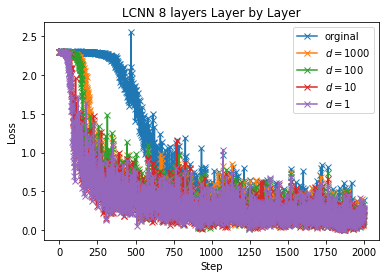

In [90]:
plt.plot(out[1][:2000],'x-',label='orginal')
plt.plot(out1000[1][:2000],'x-',label=r'$d=1000$')
plt.plot(out100[1][:2000],'x-',label=r'$d=100$')
plt.plot(out10[1][:2000],'x-',label=r'$d=10$')
plt.plot(out1[1][:2000],'x-',label=r'$d=1$')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 8 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.savefig('/content/drive/My Drive/LCNN/plot/8layertt1.pdf')

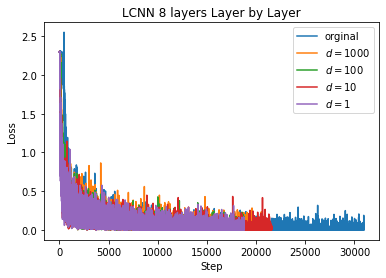

In [92]:
plt.plot(out[1],'-',label='orginal')
plt.plot(out1000[1],'-',label=r'$d=1000$')
plt.plot(out100[1],'-',label=r'$d=100$')
plt.plot(out10[1],'-',label=r'$d=10$')
plt.plot(out1[1],'-',label=r'$d=1$')

#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 8 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.savefig('/content/drive/My Drive/LCNN/plot/8layertt2.pdf')

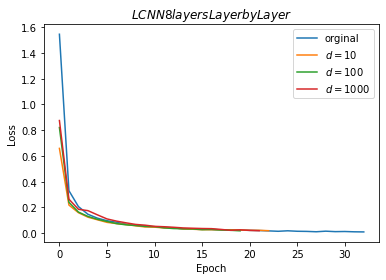

In [93]:
plt.plot(out[0],'-',label='orginal')
plt.plot(out10[0],'-',label=r'$d=10$')
plt.plot(out100[0],'-',label=r'$d=100$')
plt.plot(out1000[0],'-',label=r'$d=1000$')
#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title(r'$LCNN 8 layers Layer by Layer$')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('/content/drive/My Drive/LCNN/plot/8layerlt2.pdf')

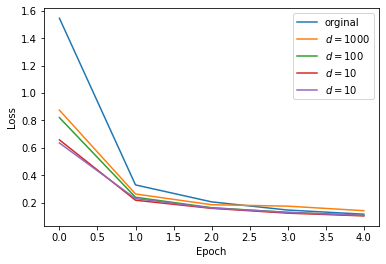

In [95]:
plt.plot(out[0][:5],'-',label='orginal')
plt.plot(out1000[0][:5],'-',label=r'$d=1000$')
plt.plot(out100[0][:5],'-',label=r'$d=100$')
plt.plot(out10[0][:5],'-',label=r'$d=10$')
plt.plot(out1[0][:5],'-',label=r'$d=10$')


plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('/content/drive/My Drive/LCNN/plot/8layerlt.pdf')

In [34]:
result['orginal']

TypeError: ignored

In [15]:
os.path.exists('learning_results.npy')

False

In [47]:
def Merge(dict1, dict2): 
    return(dict2.update(dict1)) 
filename='learning_results.npy'
if os.path.exists(filename):
    read_dictionary = np.load(filename,allow_pickle=True).item()
    result =Merge(read_dictionary,result)
    np.save(filename, result)
else:
    np.save(filename, result)

In [54]:
tt=result100['dd100'][1]
lt=result100['dd100'][0]

In [49]:
read_dictionary = np.load(filename,allow_pickle=True).item()

In [50]:
read_dictionary

In [58]:
out100=[lt,tt]

In [59]:
out=[losslist,totalloss]